# TERMINADO

In [52]:
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, StringType, IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, Imputer, VectorAssembler, MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import warnings

warnings.simplefilter("ignore")

In [53]:
# Crear la sesión de Spark
spark = SparkSession.builder.appName('pipeline_diamonds').getOrCreate()

# URL del dataset
url = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/refs/heads/master/diamonds.csv'
csv_path = 'diamonds.csv'

# Descargar el CSV
with open(csv_path, 'wb') as file:
    file.write(requests.get(url).content)

# Definir el esquema para el CSV
schema = StructType([
    StructField('carat', FloatType(), True),
    StructField('cut', StringType(), True),
    StructField('color', StringType(), True),
    StructField('clarity', StringType(), True),
    StructField('depth', FloatType(), True),
    StructField('table', FloatType(), True),
    StructField('price', IntegerType(), True),
    StructField('x', FloatType(), True),
    StructField('y', FloatType(), True),
    StructField('z', FloatType(), True),
])


# Cargar los datos en un DataFrame
df = spark.read.csv(csv_path, header=True, inferSchema=False, schema=schema)

# Mostrar los primeros 5 registros y el esquema
df.show(5)
df.printSchema()


+-----+-------+-----+-------+-----+-----+-----+----+----+----+
|carat|    cut|color|clarity|depth|table|price|   x|   y|   z|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
| 0.23|  Ideal|    E|    SI2| 61.5| 55.0|  326|3.95|3.98|2.43|
| 0.21|Premium|    E|    SI1| 59.8| 61.0|  326|3.89|3.84|2.31|
| 0.23|   Good|    E|    VS1| 56.9| 65.0|  327|4.05|4.07|2.31|
| 0.29|Premium|    I|    VS2| 62.4| 58.0|  334| 4.2|4.23|2.63|
| 0.31|   Good|    J|    SI2| 63.3| 58.0|  335|4.34|4.35|2.75|
+-----+-------+-----+-------+-----+-----+-----+----+----+----+
only showing top 5 rows

root
 |-- carat: float (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: float (nullable = true)
 |-- table: float (nullable = true)
 |-- price: integer (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- z: float (nullable = true)



In [54]:
from pyspark.sql.functions import col, sum 

# Como vamos a predecir price borramos filas donde price sea nan:
df = df.dropna(subset=['price'])

# contar nulos en todas las columnas: equivalente a pandas df.isna().sum()
df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns]).show()

+-----+---+-----+-------+-----+-----+-----+---+---+---+
|carat|cut|color|clarity|depth|table|price|  x|  y|  z|
+-----+---+-----+-------+-----+-----+-----+---+---+---+
|    0|  0|    0|      0|    0|    0|    0|  0|  0|  0|
+-----+---+-----+-------+-----+-----+-----+---+---+---+



In [55]:
# Seleccionar columnas numéricas y categóricas
numerical_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
categorical_cols = ['cut', 'color', 'clarity']
print('numerical_cols   = ', numerical_cols)
print('categorical_cols = ', categorical_cols)


numerical_cols   =  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
categorical_cols =  ['cut', 'color', 'clarity']


In [56]:
# Imputer para las columnas numéricas (usaremos la mediana)
imputer_numerical = Imputer(
    inputCols=numerical_cols,
    outputCols=[c + '_imputed' for c in numerical_cols],
    strategy='median'
)


In [57]:
# Indexers para las columnas categóricas
indexers = [
    StringIndexer(inputCol=c, outputCol=c + '_indexed', handleInvalid='keep') for c in categorical_cols
]

# OneHotEncoder para las columnas categóricas indexadas
encoders = [
    OneHotEncoder(inputCol=c + '_indexed', outputCol=c + '_onehot') for c in categorical_cols
]



In [58]:
# Escalar las columnas numéricas imputadas
assembler_numerical = VectorAssembler(
    inputCols=[c + '_imputed' for c in numerical_cols if c != 'price'],
    outputCol='numeric_features'
)

scaler = MinMaxScaler(inputCol='numeric_features', outputCol='numeric_features_scaled')



In [59]:
# Ensamblar todas las características
assembler_all = VectorAssembler(
    inputCols=['numeric_features_scaled'] + [c + '_onehot' for c in categorical_cols],
    outputCol='features'
)


In [60]:
# Pipeline para regresión sobre price
regressor = RandomForestRegressor(featuresCol='features', labelCol='price')

pipeline_regression = Pipeline(stages=[
    imputer_numerical,
    *indexers,
    *encoders,
    assembler_numerical,
    scaler,
    assembler_all,
    regressor
])



In [61]:
# Particionamiento de los datos en entrenamiento y prueba
df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)

print('df_train', df_train)
print('df_test ', df_test)


df_train DataFrame[carat: float, cut: string, color: string, clarity: string, depth: float, table: float, price: int, x: float, y: float, z: float]
df_test  DataFrame[carat: float, cut: string, color: string, clarity: string, depth: float, table: float, price: int, x: float, y: float, z: float]


In [62]:
# GridSearch con Cross-Validation para regresión
paramGrid_reg = ParamGridBuilder() \
    .addGrid(regressor.maxDepth, [5, 10]) \
    .addGrid(regressor.numTrees, [20, 50]) \
    .build()

evaluator_reg = RegressionEvaluator(
    labelCol="price",
    predictionCol="prediction",
    metricName="rmse"
)

crossval_reg = CrossValidator(
    estimator=pipeline_regression,
    estimatorParamMaps=paramGrid_reg,
    evaluator=evaluator_reg,
    numFolds=3,
    seed=42
)


In [63]:
# Ajustar el modelo de regresión con validación cruzada
cv_model_reg = crossval_reg.fit(df_train)


In [64]:
# Realizar predicciones con el modelo ajustado
df_pred_reg = cv_model_reg.transform(df_test)


In [65]:
# Evaluar las métricas de rendimiento para regresión
rmse = evaluator_reg.evaluate(df_pred_reg)
print(f'RMSE del modelo de regresión: {rmse}')



RMSE del modelo de regresión: 760.7807849942457


#### Clasificación

In [66]:
# Como vamos a predecir cut borramos filas donde cut sea nan:
# df = df.dropna(subset=['cut'])


In [67]:
categorical_cols_indexed = [c + '_indexed' for c in categorical_cols]
print(categorical_cols_indexed)

['cut_indexed', 'color_indexed', 'clarity_indexed']


In [68]:
# Imputer con la moda para las columnas categóricas indexadas
imputer_categorical = Imputer(
    inputCols=categorical_cols_indexed,
    outputCols=[c + '_imputed' for c in categorical_cols_indexed],
    strategy='mode'
)
categorical_cols_indexed_imputed = [c + '_imputed' for c in categorical_cols_indexed]
print(categorical_cols_indexed_imputed)

['cut_indexed_imputed', 'color_indexed_imputed', 'clarity_indexed_imputed']


In [69]:
# Definir el clasificador
classifier = RandomForestClassifier(featuresCol='features', labelCol='label')


In [70]:
# Indexar la etiqueta 'cut' para convertirla en valores numéricos
indexer_label = StringIndexer(inputCol='cut', outputCol='label', handleInvalid='keep')

# Indexadores para las características categóricas
indexers_features = [
    StringIndexer(inputCol=c, outputCol=c + '_indexed', handleInvalid='keep') for c in ['color', 'clarity']
]

# OneHotEncoder para las columnas categóricas indexadas
encoders_onehot = [
    OneHotEncoder(inputCol=c + '_indexed', outputCol=c + '_onehot') for c in ['color', 'clarity']
]

# Ensamblar características numéricas
assembler_numerical = VectorAssembler(
    inputCols=['carat', 'depth', 'table', 'x', 'y', 'z'],
    outputCol='numeric_features'
)

# Escalar características numéricas
scaler = MinMaxScaler(inputCol='numeric_features', outputCol='numeric_features_scaled')

# Ensamblar todas las características
assembler_all = VectorAssembler(
    inputCols=['numeric_features_scaled'] + [c + '_onehot' for c in ['color', 'clarity']],
    outputCol='features'
)

# Definir el clasificador
classifier = RandomForestClassifier(featuresCol='features', labelCol='label')


In [71]:
# Crear el pipeline de clasificación corregido
pipeline_classification = Pipeline(stages=[
    indexer_label,        # Indexar la etiqueta 'cut' correctamente como 'label'
    *indexers_features,   # Indexar características categóricas
    *encoders_onehot,     # Aplicar OneHotEncoder
    assembler_numerical,  # Ensamblar características numéricas
    scaler,               # Escalar características numéricas
    assembler_all,        # Ensamblar todas las características
    classifier            # Aplicar el clasificador
])


In [72]:
# Particionamiento de los datos en entrenamiento y prueba
df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)

print('df_train', df_train)
print('df_test ', df_test)


df_train DataFrame[carat: float, cut: string, color: string, clarity: string, depth: float, table: float, price: int, x: float, y: float, z: float]
df_test  DataFrame[carat: float, cut: string, color: string, clarity: string, depth: float, table: float, price: int, x: float, y: float, z: float]


In [73]:
# Definir la grilla de hiperparámetros para la búsqueda
paramGrid_clf = ParamGridBuilder() \
    .addGrid(classifier.maxDepth, [5, 10]) \
    .addGrid(classifier.numTrees, [20, 50]) \
    .build()
    


In [74]:
# Definir el evaluador para la clasificación
evaluator_clf = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)


In [75]:
# Configurar el CrossValidator
crossval_clf = CrossValidator(
    estimator=pipeline_classification,
    estimatorParamMaps=paramGrid_clf,
    evaluator=evaluator_clf,
    numFolds=3,
    seed=42
)


In [76]:
# Ajustar el modelo de clasificación con validación cruzada
cv_model_clf = crossval_clf.fit(df_train)


In [77]:
# Realizar predicciones en el conjunto de prueba
df_pred_cv_clf = cv_model_clf.transform(df_test)
print('df_pred_cv_clf ', df_pred_cv_clf)

df_pred_cv_clf  DataFrame[carat: float, cut: string, color: string, clarity: string, depth: float, table: float, price: int, x: float, y: float, z: float, label: double, color_indexed: double, clarity_indexed: double, color_onehot: vector, clarity_onehot: vector, numeric_features: vector, numeric_features_scaled: vector, features: vector, rawPrediction: vector, probability: vector, prediction: double]


In [78]:
# Evaluar las métricas de rendimiento
accuracy = evaluator_clf.evaluate(df_pred_cv_clf)
print('Accuracy:', accuracy)



Accuracy: 0.7061803444782169


#### Visualización de Resultados de Regresión:

#### Distribución de Errores: Calcula los errores de predicción (residuos) y visualiza su distribución para verificar la homocedasticidad y la normalidad.

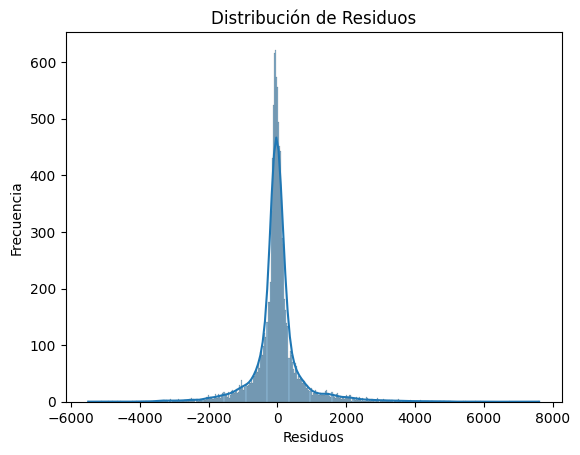

In [79]:
  import matplotlib.pyplot as plt
  import seaborn as sns

  # Calcular residuos
  df_pred_reg = df_pred_reg.withColumn('residual', df_pred_reg['price'] - df_pred_reg['prediction'])

  # Convertir a Pandas para visualización
  df_residuals = df_pred_reg.select('residual').toPandas()

  # Histograma de residuos
  sns.histplot(df_residuals['residual'], kde=True)
  plt.title('Distribución de Residuos')
  plt.xlabel('Residuos')
  plt.ylabel('Frecuencia')
  plt.show()


#### Gráfico de Predicción vs. Realidad: Compara las predicciones del modelo con los valores reales para evaluar la precisión del modelo.

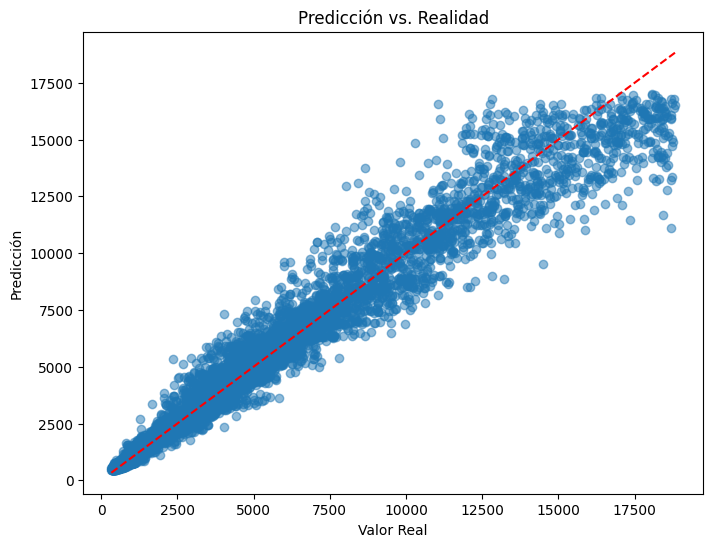

In [80]:
  # Convertir a Pandas para visualización
  df_comparison = df_pred_reg.select('price', 'prediction').toPandas()

  # Gráfico de dispersión
  plt.figure(figsize=(8, 6))
  plt.scatter(df_comparison['price'], df_comparison['prediction'], alpha=0.5)
  plt.plot([df_comparison['price'].min(), df_comparison['price'].max()],
           [df_comparison['price'].min(), df_comparison['price'].max()],
           color='red', linestyle='--')
  plt.title('Predicción vs. Realidad')
  plt.xlabel('Valor Real')
  plt.ylabel('Predicción')
  plt.show()


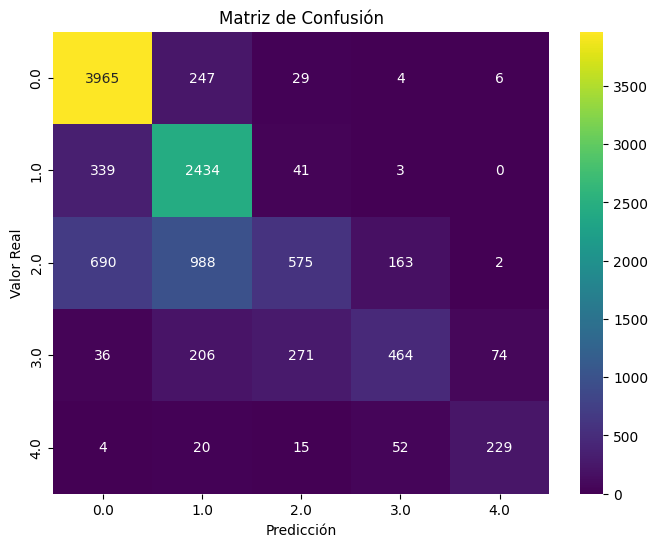

              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85      4251
         1.0       0.62      0.86      0.73      2817
         2.0       0.62      0.24      0.34      2418
         3.0       0.68      0.44      0.53      1051
         4.0       0.74      0.72      0.73       320

    accuracy                           0.71     10857
   macro avg       0.69      0.64      0.64     10857
weighted avg       0.70      0.71      0.67     10857



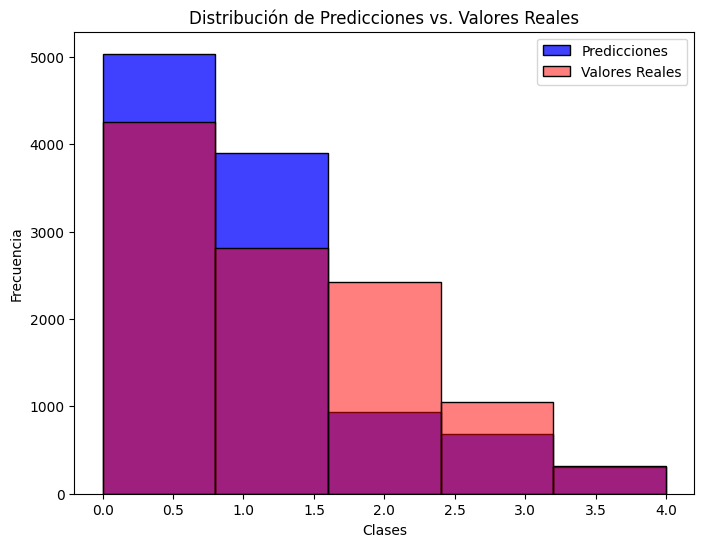

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convertir los datos de predicción a Pandas para la visualización
df_pred_pd = df_pred_cv_clf.select('label', 'prediction').toPandas()

# Matriz de Confusión
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cm = confusion_matrix(df_pred_pd['label'], df_pred_pd['prediction'])
labels = sorted(df_pred_pd['label'].unique())

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm, labels)

# Reporte de Clasificación
from sklearn.metrics import classification_report
print(classification_report(df_pred_pd['label'], df_pred_pd['prediction']))

# Distribución de Predicciones
plt.figure(figsize=(8, 6))
sns.histplot(df_pred_pd['prediction'], bins=len(labels), kde=False, color='blue', label='Predicciones')
sns.histplot(df_pred_pd['label'], bins=len(labels), kde=False, color='red', label='Valores Reales', alpha=0.5)
plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Distribución de Predicciones vs. Valores Reales')
plt.legend()
plt.show()
